In [601]:
import random
import time

import torch
from torchvision import transforms
import torch.nn.functional as F
import torch.nn as nn
import os
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from random import randint
import pandas as pd
from SSWQ import SSWQ_V1
from sklearn.preprocessing import LabelEncoder

In [602]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"{device}: {torch.cuda.get_device_name(0)}")

cuda:0: NVIDIA GeForce GTX 1080


In [603]:
sample_images_path = 'D:\data_waste-classification\evaluation\sample_images\\'
data_path = "D:\data_waste-classification\evaluation\evaluation_images\\"
#models_path = "D:\data_waste-classification\evaluation\models_woi\\"
models_path = "D:\data_waste-classification\evaluation\models_wi\\"

In [604]:
images = []
for file in os.listdir(sample_images_path):
        images.append(file)

In [605]:
image = []
labels = []

for file in os.listdir(data_path):
    if file == 'glas':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('glas')
    if file == 'organic':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('organic')
    if file == 'paper':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('paper')
    if file == 'restmuell':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('restmuell')
    if file == 'wertstoff':
        for c in os.listdir(os.path.join(data_path, file)):
            image.append(c)
            labels.append('wertstoff')

data = {'Images': image, 'labels': labels}
data = pd.DataFrame(data)
lb = LabelEncoder()
data['encoded_labels'] = lb.fit_transform(data['labels'])

In [606]:
waste_types = {0: 'glas', 1: 'organic', 2: 'paper', 3: 'restmuell', 4: 'wertstoff'}

In [607]:
data

,Images,labels,encoded_labels
0,1652563330809505073032262086032.jpg,glas,0
1,1653383557786.jpg,glas,0
2,1653383557802.jpg,glas,0
3,1653383557819.jpg,glas,0
4,1653383557835.jpg,glas,0
...,...,...,...
1629,IMG_20220525_224608.jpg,wertstoff,4
1630,IMG_20220525_224610.jpg,wertstoff,4
1631,IMG_20220525_224753.jpg,wertstoff,4
1632,IMG_20220525_224759.jpg,wertstoff,4


In [608]:
from torchvision import transforms

transform_val = transforms.Compose(
    [transforms.Resize((256,256), interpolation= transforms.InterpolationMode.BICUBIC),
     transforms.ToTensor(),
     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

In [609]:
from torch.utils.data import Dataset

class GarbageDataset(Dataset):
    def __init__(self, img_data, img_path, transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data

    def __len__(self):
        return len(self.img_data)

    def __getitem__(self, index):
        img_name = os.path.join(self.img_path, self.img_data.iloc[index].labels, self.img_data.iloc[index].Images)
        image = Image.open(img_name).convert('RGB')
        #image = image.resize((300, 300))
        label = torch.tensor(self.img_data.iloc[index].encoded_labels)
        if self.transform is not None:
            image = self.transform(image)
        return image, label, img_name

In [610]:
from torch.utils.data import DataLoader

test_dataset = GarbageDataset(data, data_path, transform_val)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False)
sample_img = list()
labels = list("" for _ in range(25))
encoded_labels = list(0 for _ in range(25))
for file in os.listdir(sample_images_path):
        sample_img.append(file)
sample_data = {'Images': sample_img, 'labels': labels, 'encoded_labels': encoded_labels}
sample_dataset = pd.DataFrame(sample_data)
sample_dataset = GarbageDataset(sample_dataset, sample_images_path, transform_val)
sample_dataloader = DataLoader(sample_dataset, batch_size=64, shuffle=False)

In [611]:
import numpy as np

def img_display(img):
    MEAN = torch.tensor([0.485, 0.456, 0.406])
    STD = torch.tensor([0.229, 0.224, 0.225])

    img = img * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [612]:
def accuracy(out, labels):
    _, pred = torch.max(out, dim=1)
    return torch.sum(pred == labels).item()

In [613]:
#---------------------------------------------------------------

In [614]:
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.255]
MEAN = torch.tensor(mean)
STD = torch.tensor(std)
mean50 = [0.5, 0.5, 0.5]
std50 = [0.5, 0.5, 0.5]
MEAN50 = torch.tensor(mean)
STD50 = torch.tensor(std)

transform_mean_std_50 = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)]
)
transform_mean_std_other = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean, std)]
)
def img_display(img):
    img = img * STD[:, None, None] + MEAN[:, None, None]
    #img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    npimg = np.transpose(npimg, (1, 2, 0))
    return npimg

In [615]:
from torchvision import models
from torch import nn
from efficientnet_pytorch import EfficientNet

def editModel(model, path, classes):
    if model == "resnet50":
        model = models.resnet50(pretrained=False)
        num_ftrs = model.fc.in_features
        model.fc = nn.Linear(num_ftrs, classes)
        model.fc = model.fc.cuda()
    if model == "VGG16":
        model = models.vgg16(pretrained=False)
        in_features = model.classifier[0].in_features
        model.classifier = nn.Linear(in_features, classes)
    if model == "efficientnet-b3" or model == "efficientnet-b4":
        model = EfficientNet.from_pretrained(model,num_classes=classes)
    if model == "SSWQV1":
        model = SSWQ_V1(num_classes=classes, dropout=0.5, hidden_layer1=512, hidden_layer2=2048)

    model.load_state_dict(torch.load(models_path+path, map_location='cuda:0'))
    model.cuda()
    model.eval()
    return model


model1 = {
    'name': "VGG16",
    "model": editModel("VGG16", "vgg16.pt", 5),
    "transform": transform_mean_std_other,
    "resize": (256, 256)
}
model2 = {
    'name': "resnet50",
    "model": editModel("resnet50", "resnet50.pt", 5),
    "transform": transform_mean_std_other,
    "resize": (256, 256)
}
model3 = {
    'name': "eff_b3",
    "model": editModel("efficientnet-b3", "eff_b3.pt", 5),
    "transform": transform_mean_std_other,
    "resize": (256, 256)
}
model4 = {
    'name': "eff_b4",
    "model": editModel("efficientnet-b4", "eff_b4.pt", 5),
    "transform": transform_mean_std_other,
    "resize": (256, 256)
}
model5 = {
    'name': "SSWQV1",
    "model": editModel("SSWQV1", "sswq_v1.pt", 5),
    "transform": transform_mean_std_other,
    "resize": (256, 256)
}

_models = [model1, model2, model3, model4, model5]

Loaded pretrained weights for efficientnet-b3
Loaded pretrained weights for efficientnet-b4


In [616]:
def predict_with_models(models, plots_x, plots_y):
    garbage_types = {0: 'glas', 1: 'organic', 2: 'paper', 3: 'restmuell', 4: 'wertstoff'}
    if plots_x * plots_y > len(images):
        return -1
    random.shuffle(images)
    fig, axis = plt.subplots(plots_x, plots_y, figsize=((plots_x+1)*5, (plots_y+4)*5))



    for i, ax in enumerate(axis.flat):
        with torch.no_grad():
            imagePath = os.path.join(sample_images_path, images[i])
            image = Image.open(imagePath).convert('RGB')
            ax.imshow(image)
            classes_predicted = []
            probs_predicted = []
            output_string = ""
            for model in models:
                output_string += model['name'] + ' | '
                imagePath = os.path.join(sample_images_path, images[i])
                image = Image.open(imagePath).convert('RGB')
                image = image.resize(model['resize'])
                transform = model['transform']
                image = transform(image)
                image = image.cuda()
                image_tensor = image.unsqueeze_(0)
                image_tensor.cuda()
                output_ = model['model']((image_tensor))
                softmax = nn.LogSoftmax(1)
                output_ = softmax(output_)
                output_numpy = torch.exp(output_).to('cpu').numpy()
                output_ = output_.argmax()
                classes_predicted.append(str(garbage_types[output_.item()]))
                probs_predicted.append(str(round(100 * output_numpy[0][output_.item()], 0)))

            output_string += '\n'
            for c in classes_predicted:
                output_string += c +  ' | '
            output_string += '\n'
            for p in probs_predicted:
                output_string += p + '% | '
            ax.set_title(output_string, fontsize=15)  # add label

In [617]:
#predict_with_models(_models, 4, 3)

In [618]:
#---------------------------------------------------------------

In [619]:
model = _models[4]["model"]

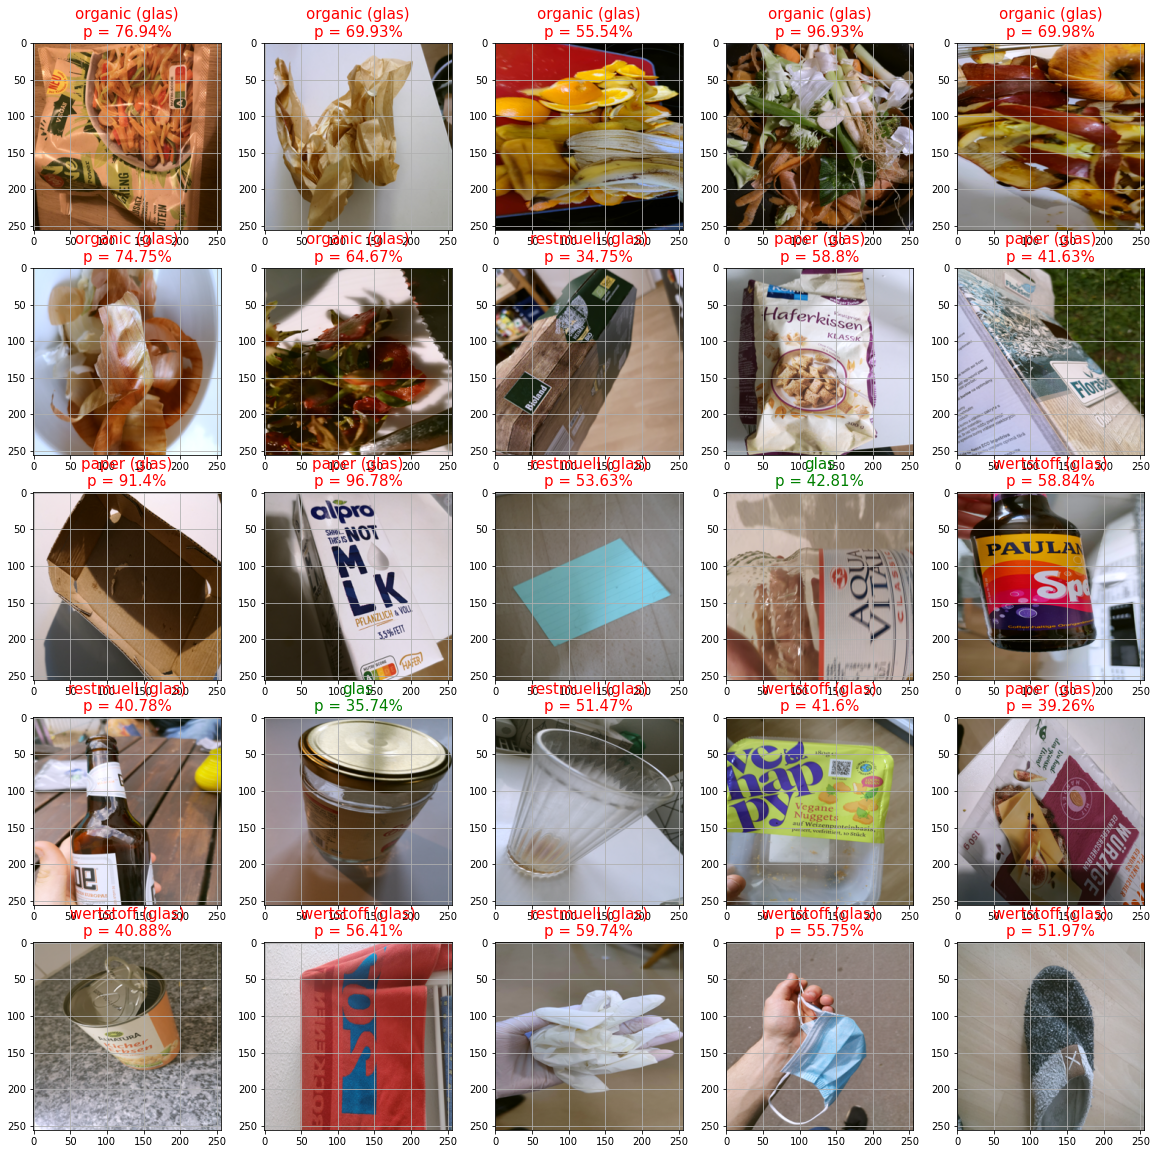

In [620]:
dataiter = iter(sample_dataloader)
images, labels, path = dataiter.next()

# Viewing data examples used for training
fig, axis = plt.subplots(5, 5, figsize=(20, 20))
with torch.no_grad():
    for ax, image, label, path in zip(axis.flat, images, labels, path):
        ax.grid(None)
        ax.set_facecolor((1,1,1))
        #ax.imshow(img_display(image))  # add image
        ax.imshow(np.clip(img_display(image), 0, 1))  # add image
        image, label = image.to(device), label.to(device)
        imagetensor = image.unsqueeze(0)
        imagetensor.to(device)
        output = model(imagetensor)
        softmax = nn.LogSoftmax(1)
        output = softmax(output)
        outputnumpy = torch.exp(output).to('cpu').numpy()
        output = output.argmax()
        k = output.item() == label.item()
        color = 'green'
        highest_probability = str(round(100 * outputnumpy[0][output.item()], 2))
        string = str(waste_types[output.item()]) + "\np = " + highest_probability + "%"
        if not k:
            color = 'red'
            string = str(waste_types[output.item()]) + " (" + str(waste_types[label.item()]) + ")\np = " + highest_probability + "%"
        ax.set_title(string, fontsize=15, color=color)  # add label

In [621]:
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)

a = []
b = []
dict = {
    'paper':[0,0,0],
    'wertstoff':[0,0,0],
    'restmuell':[0,0,0],
    'glas':[0,0,0],
    'organic':[0,0,0],
}

start_time = time.time()
elapsed_time = 0
with torch.no_grad():
    for data_t, target_t, _ in test_dataloader:
        target_t = target_t.type(torch.FloatTensor)
        data_t, target_t = data_t.to(device), target_t.to(device)  # on GPU
        for image, label in zip(data_t, target_t):
            imagetensor = image.unsqueeze_(0)
            imagetensor.to(device)
            output = model(image)
            output = output.argmax()
            k = output.item() == label.item()
            a.append(k)
            b.append(waste_types[label.item()])
            # Absolute Count
            dict[waste_types[label.item()]][0] += 1
            if k: # True
                dict[waste_types[label.item()]][1] += 1
            else: # False
                dict[waste_types[label.item()]][2] += 1
end_time = time.time()
elapsed_time += end_time - start_time

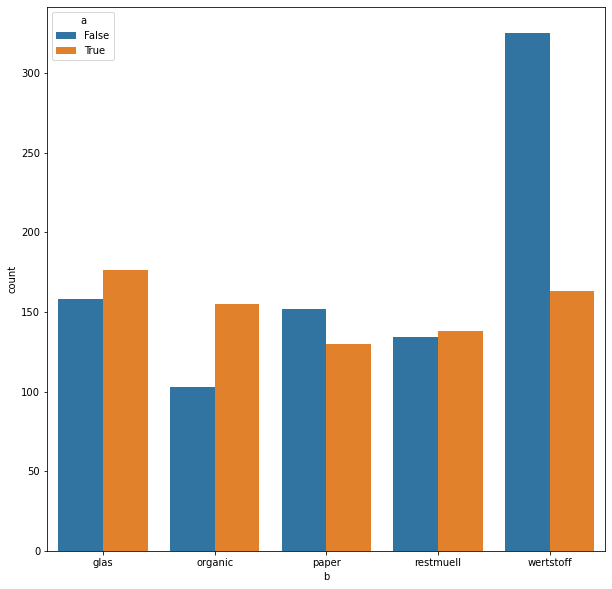

In [622]:
import seaborn as sns
df = {"a":a, "b":b}
df = pd.DataFrame(df)
fig, ax1 = plt.subplots(figsize=(10, 10))
sns.countplot(x=df['b'], hue=df['a'], ax=ax1)
plt.savefig("./sswq_v1_wi" + '/countplot.png', format='png',bbox_inches='tight', dpi=300)
plt.savefig("./sswq_v1_wi" + '/countplot.pdf', format='pdf',bbox_inches='tight', dpi=300)
plt.savefig('./sswq_v1_wi/images_per_class_our_images.svg', dpi=300)

In [623]:
print(dict)

{'paper': [282, 130, 152], 'wertstoff': [488, 163, 325], 'restmuell': [272, 138, 134], 'glas': [334, 176, 158], 'organic': [258, 155, 103]}


In [624]:
def accuracy(all,tp):
    return tp/all

In [625]:
accs = list()
total_acc = 0
for label in dict:
    accs.append(accuracy(dict[label][0],dict[label][1]))
    total_acc += accs[-1]
total_acc /= 5

In [626]:
accs

[0.46099290780141844,
 0.33401639344262296,
 0.5073529411764706,
 0.5269461077844312,
 0.6007751937984496]

In [627]:
total_acc

0.4860167088006785

In [628]:
print(elapsed_time)

273.3069005012512
